<a href="https://colab.research.google.com/github/BankNatchapol/Comparison-Of-Quantum-Gradient/blob/main/concept_implementation/hamiltonians_expected_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer
from pennylane.qaoa import maxcut

import networkx as nx
import matplotlib.pyplot as plt

In [6]:
graph = nx.Graph(((0, 2), (1, 2), (3, 2)))

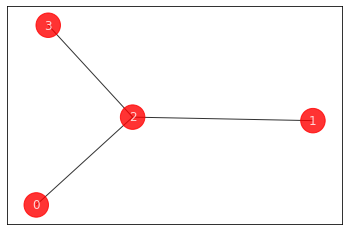

In [7]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos, font_color="white")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

colors = ['r' for node in graph.nodes()]
pos = nx.spring_layout(graph)
draw_graph(graph, colors, pos)

In [8]:
hamiltonian_maxcut, hamiltonian_mixer = maxcut(graph)
print(hamiltonian_maxcut)

  (-1.5) [I0]
+ (0.5) [Z0 Z2]
+ (0.5) [Z2 Z1]
+ (0.5) [Z2 Z3]


Hamiltonian of graph is 
 $$-1.5 I_0
+ 0.5 Z_0 Z_2
+ 0.5 Z_1 Z_2 
+ 0.5 Z_2 Z_3$$
$$= -1.5I_0I_1I_2I_3+ 0.5Z_0I_1Z_2I_3 + 0.5 I_0Z_1Z_2I_3+ 0.5I_0I_1Z_2Z_3$$

In [3]:
num_wires = 4
dev = qml.device("default.qubit", wires=num_wires)

Can be represent as combination of 4 measurement basis circuits

In [152]:
def Identity(wires):
  matrix = np.eye(2, 2)
  qml.QubitUnitary(matrix, wires=wires)

def ham_term_1(): # (-1.5) [I0]
  Identity(wires=0)
  Identity(wires=1)
  Identity(wires=2)
  Identity(wires=3)

def ham_term_2(): # (0.5) [Z0 Z2]
  qml.PauliZ(wires=0)
  Identity(wires=1)
  qml.PauliZ(wires=2)
  Identity(wires=3)

def ham_term_3(): # (0.5) [Z2 Z1]
  Identity(wires=0)
  qml.PauliZ(wires=1)
  qml.PauliZ(wires=2)
  Identity(wires=3)

def ham_term_4():# (0.5) [Z2 Z3]
  Identity(wires=0)
  Identity(wires=1)
  qml.PauliZ(wires=2)
  qml.PauliZ(wires=3)

@qml.qnode(dev)
def printer(ham_term):
  ham_term.numpy()()
  return qml.state()

In [155]:
def drawing(term):
  circuit_draw = qml.draw(printer)(term)[:-26]
  for i in range(num_wires):
    circuit_draw = circuit_draw.replace(f"U{i}", f"I─")
  return circuit_draw

coeffs = list(reversed(hamiltonian_maxcut.coeffs))
for i, term in enumerate([ham_term_1, ham_term_2, ham_term_3, ham_term_4]): 
  print("Coefficient: ", coeffs[i])
  print(drawing(term), "\n")

Coefficient:  -1.5
 0: ──I───╭┤ State 
 1: ──I───├┤ State 
 2: ──I───├┤ State 
 3: ──I───╰┤ State 

Coefficient:  0.5
 0: ──Z───╭┤ State 
 1: ──I───├┤ State 
 2: ──Z───├┤ State 
 3: ──I───╰┤ State 

Coefficient:  0.5
 0: ──I───╭┤ State 
 1: ──Z───├┤ State 
 2: ──Z───├┤ State 
 3: ──I───╰┤ State 

Coefficient:  0.5
 0: ──I───╭┤ State 
 1: ──I───├┤ State 
 2: ──Z───├┤ State 
 3: ──Z───╰┤ State 



get expected value using Pennylane

In [221]:
var = [[0.07550447, -0.0284327 , -3.12138728, -0.04987069,  0.04327038,
       -0.11507693,  0.08724059, -0.03806035,  0.01595195, -0.01246852,
        0.0731054 , -0.10300704, -0.01612086, -0.01920272,  0.05668847,
       -0.05499456]]
       
def mixer(var): # mixing state 
  for wire in range(num_wires):
    qml.RX(var[0+wire], wires=wire)
    qml.RZ(var[1+wire], wires=wire)

@qml.qnode(dev)
def pennylane_expval(hamiltonian, var):
  for v in var:
    mixer(v)

  return qml.expval(hamiltonian.numpy())

In [222]:
pennylane_expval(hamiltonian_maxcut, var)

-2.997445988651603

get expected value using concept implementation

In [216]:
def concept_expval(coeffs, var):
  @qml.qnode(dev)
  def term1():
    for v in var:
      mixer(v)

    ham_term_1()

    for v in reversed(var):
      qml.adjoint(mixer)(v)

    return qml.state()

  @qml.qnode(dev)
  def term2():
    for v in var:
      mixer(v)

    ham_term_2()

    for v in reversed(var):
      qml.adjoint(mixer)(v)

    return qml.state()
  
  @qml.qnode(dev)
  def term3():
    for v in var:
      mixer(v)

    ham_term_3()

    for v in reversed(var):
      qml.adjoint(mixer)(v)

    return qml.state()
  
  @qml.qnode(dev)
  def term4():
    for v in var:
      mixer(v)

    ham_term_4()

    for v in reversed(var):
      qml.adjoint(mixer)(v)

    return qml.state()

  total = 0
  values = [term1()[0], term2()[0], term3()[0], term4()[0]]
  for i, c in enumerate(coeffs):
    total += c*values[i]
  
  return round(float(total.real), 15)

In [225]:
coeffs = [-1.5, 0.5, 0.5, 0.5]
print("Pennylane expected value              : ", pennylane_expval(hamiltonian_maxcut, var))
print("Concept implementation expected value : ", concept_expval(coeffs, var))

Pennylane expected value              :  -2.997445988651603
Concept implementation expected value :  -2.997445988651603
